In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import MaxNLocator

from tqdm import tqdm

# Basic Idea

For each day we take 15 summaries of the $150$ covariates $\{x_i(t)\}_{i=1}^{150}$, and the summary $x_s(t) \in \mathbb{R}^{15}$
We denote the confirmed cases data for the training period $y_{train}$. Since this is count data so we employ a Poisson regression driven by a laten Gaussian process as a regression model. This is as follows:$
f(t) = \mathcal{GP}(\mu, K_{mat}(x_s,x^{'}_s))$ 
and $y_{train}(t) \sim \mathcal{P}(exp(f(t)))$


In [2]:
# A few dictionaries fo storing fitting and plotitng info.
int_date_dict = {'DE_BW':13, 'DE_BY':10, 'DE_BE':13, 'DE_HE':10, 'DE_NI':10, 'DE_NW':10, 'DE_RP':10, 'DK':11, 'NO':6, 'SE':22}
abrv_dict = {'NO':'Norway', 'DK':'Denmark', 'SE':'Sweden', 'DE_BY':'Bavaria', 'DE_BE':'Berlin', 'DE_HE':'Hesse',
             'DE_NI':'Lower Saxony', 'DE_NW':'North Rhine-Westphalia', 'DE_RP':'Rhineland Palatinate', 'DE_BW':'Baden Wurttemberg'}

In [6]:
# Parameters. Note for regions use e.g. 'DE_BE' (Germany/Berlin), for just country use e.g. 'SE'
region = 'DE_NI'
metric = 'new_cases' # 'cases' for cumulative, 'new_cases' for daily
int_date = int_date_dict[region]
start_date = 0
assumed_lag = 5 # Note needs a 6 day assumed lag for DE_BW
fit_date = int_date + assumed_lag + 1
num_covariates =  15 # 'all' or integer

In [7]:
#### DATA PREPROCESSING ####
# Get the observed data. This CSV should contain just the observable of interest
case_data = np.loadtxt('./GP_input_data/{}_{}.csv'.format(region, metric),int,skiprows=1,delimiter=',')
# Get the simulated data and split to train and test
case_data_covariates_raw_1 = np.loadtxt('GP_input_data/posteriors_{}_{}.csv'.format(metric, region),
                                      skiprows=1,
                                      delimiter=',')
#case_data_covariates_raw_2 = np.loadtxt('simulated_data/{}_{}_{}_15gen_test_q05_2.csv'.format(data_type, metric, region, assumed_lag),
#                                      skiprows=1,
#                                      delimiter=',')
case_data_covariates_1 = case_data_covariates_raw_1[start_date:fit_date,1:] 
#case_data_covariates_2 = case_data_covariates_raw_2[start_date:fit_date,1:] 
#dotw_cov = [x%7 for x,_ in enumerate(case_data_covariates)]
#case_data_covariates = np.concatenate(case_data_covariates, cotw_cov, axis=1)
case_data_covariates_test_1 = case_data_covariates_raw_1[fit_date:,1:]
#case_data_covariates_test_2 = case_data_covariates_raw_2[fit_date:,1:]
# need to know how much sim data we have
num_data_points = len(case_data_covariates_raw_1)
# train/test covariates (SEIR simulations)
X_train = np.log1p(case_data_covariates_1)
X_test = np.log1p(case_data_covariates_test_1)[:]
# train/test observations (e.g. cases)
y_train = case_data[start_date:fit_date,1]
y_test = case_data[fit_date:num_data_points,1] 
# time references for testing and training
time_train = case_data[start_date:fit_date,0] 
time_test = case_data[fit_date:num_data_points,0]

In [10]:
# Check that the lengths arent going to be a problem
print("X_test = {}, y_test = {}, time_test = {}".format(len(X_test), len(y_test), len(time_test)))
assert len(X_test) == len(y_test)+15 == len(time_test)+15

X_test = 22, y_test = 7, time_test = 7


Text(0.5, 0, 'Log Test Covariates')

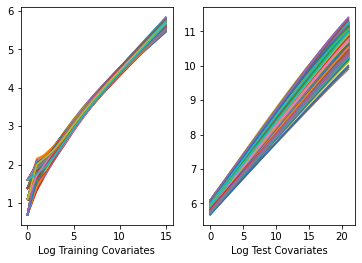

In [11]:
plt.subplot(1,2,1)
plt.plot(X_train);
plt.xlabel('Log Training Covariates')
plt.subplot(1,2,2)
plt.plot(X_test);
plt.xlabel('Log Test Covariates')

## Using percentiles for reducing dimension
Rather than using all the covariates, we can use a subset of covariates. 

In [12]:
# Grab either all covariates, or an evenly distributed sample
if num_covariates != 'all':
    assert type(num_covariates) == int, 'num_covariates should be "all" or int.'
    assert num_covariates < np.shape(X_train)[1], 'num_covariants should be strictly less than total simulations.'
    samples = np.linspace(2.5,97.5,num_covariates)

    X = np.vstack([(np.percentile(X_train, x, axis=1)) for x in samples]).T
    X_new = np.vstack([(np.percentile(X_test, x, axis=1))for x in samples]).T

else:
    X = X_train
    X_new = X_test

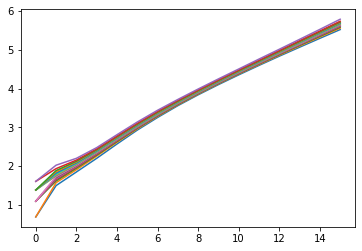

In [13]:
plt.plot(X)

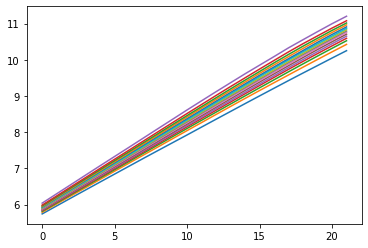

In [14]:
plt.plot(X_new)

In [15]:
# Add in a day of the week covariate
day_of_week = np.asarray([(i%7)+1 for i in range(3,num_data_points+3)])[:,np.newaxis] 
pre_dotw = day_of_week[:len(X)]
X = np.concatenate((pre_dotw,X),axis=1)
post_dotw = day_of_week[len(X):]
X_new = np.concatenate((post_dotw,X_new),axis=1)
shape = np.shape(X)[1]

# The Probabilistic model for the regression
Note that we take a Bayesian approach to fit the GP parameters, thus we place priors on the GP covariance parameters. We have used a Matern3/2 kernel for the covariance. We used a simple linear regression model for the GP mean function, and place appropriate priors on the intercept and coefficient vectors.

In [ ]:
##Note that it sometimes has a few false starts. Once it gets past a few hundered steps it is usually fine!
with pm.Model() as gp_model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1,shape=shape-1)
    η = pm.HalfCauchy("η", beta=5)
    ℓℓ = pm.Gamma("ℓℓ", alpha=2, beta=1)
    ηη = pm.HalfCauchy("ηη", beta=5)  
    
    # Covariance kernel:   
    cov1 = η**2 * pm.gp.cov.Matern32(input_dim=shape-1,ls= ℓ,active_dims=range(1,16))
    cov2 = ηη**2 * pm.gp.cov.Matern32(input_dim=1,ls= ℓℓ,active_dims=range(1))
    cov=cov1 + cov2

    # Prior distributions:
    beta = pm.StudentT('beta', nu=5, mu=0, sigma=1, shape=shape) # <---- shape =15 since we are using 15 summaries as covariates
    b = pm.StudentT('b', nu=5, mu=0, sigma=1) 
    al = pm.Gamma('al',2,0.5)
    lin_func = pm.gp.mean.Linear(coeffs=beta, intercept=b)
    # Deifne latent GP model

    gp = pm.gp.Latent(mean_func=lin_func,cov_func=cov)


    f = gp.prior("f", X=X) 
    # Initialise weights (all ones)
    w = [1 for x in y_train]
    y_ = pm.NegativeBinomial("y", mu=pm.math.exp(f), alpha=al, observed=y_train)
    # Run sampler. Note need 2 chains for assess mixing efficiency
    trace = pm.sample(1000, chains=2, target_accept=0.98)


In [18]:
# Check for mixing of parameters. Ideally we want well mixed prior distributions.
# If the priors do not overlap a decent amount then it may be necessary to run again with more samples.
pm.traceplot(trace, var_names=["η", "ℓ", "beta","b","al"])

In [19]:
# Grab some the ouputs and tidy up
X_pred = np.vstack((X,X_new))
X_pred.shape
X_pred = np.nan_to_num(X_pred, nan=0.0, neginf=0, posinf=0)
time_full = np.hstack((time_train,time_test))
time_full.shape
y_full = np.hstack((y_train,y_test))

In [22]:
# add the GP conditional to the model, given the new X values
with gp_model:
    f_full = gp.conditional("f_pred", X_pred)##

## Sample from the GP conditional distribution. This can take a couple of hours. 
with gp_model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_full,al], samples=1000)

p_exp =np.zeros((1000,len(y_full)+15))
p_array = pred_samples["f_pred"]
for i in range(1000):
    p_exp[i,:] = (np.exp(p_array[i,:])).astype(np.float64)
    
gp_pred = np.zeros((1000,len(y_full)+15))
alpha = pred_samples["al"]#[::2]
for i in tqdm(range(1000)):
    gp_pred[i,:] = pm.NegativeBinomial.dist(mu=p_exp[i,:], alpha=alpha[i]).random()

100%|██████████| 100/100 [09:11<00:00,  5.51s/it]


In [31]:
# Set up some reference points for plotting
rel_date = int_date - start_date
time = np.linspace(0,len(y_full)+14, len(y_full)+15)
gp_center = np.percentile(gp_pred.T,50,axis=1)
gp_5 = np.percentile(gp_pred.T,5,axis=1)
gp_25 = np.percentile(gp_pred.T,25,axis=1)
gp_75 = np.percentile(gp_pred.T,75,axis=1)
gp_95 = np.percentile(gp_pred.T,95,axis=1)
sim_med = np.median(case_data_covariates_raw_1, axis=1)
# Turn this into a pickled dictionary
data_dict = {'time':time, 'gp_center':gp_center, 'gp_5':gp_5, 'gp_25':gp_25,
             'gp_75':gp_75, 'gp_95':gp_95, 'sim_med':sim_med, 'y_full':y_full,
             'metric':metric, 'region':abrv_dict[region]}

with open('{}_{}.dictionary'.format(region, metric, assumed_lag), 'wb') as config_dictionary_file:
  pickle.dump(data_dict, config_dictionary_file)

In [ ]:
## Plotting
with open('{}_{}.dictionary'.format(region, metric, assumed_lag), 'rb') as config_dictionary_file:
    data_dict = pickle.load(config_dictionary_file)
samples = np.linspace(2.5,97.5,25)####Sanmitra doing this forcibly
covariates = [np.percentile(case_data_covariates_raw_1, x, axis=1) for x in samples] 
time = data_dict['time']

fig = plt.figure(figsize=(12,6))

for i,x in enumerate(covariates):
    if i==0:
        plt.plot(time[:],x[start_date:], 'r', alpha=0.2, label='Training covariates')
    else:
        plt.plot(time[:],x[start_date:], 'r', alpha=0.2)

plt.rc('font', size=12) 
plt.plot(time[:],data_dict['sim_med'][:], 'r', label='Mean prediction from ABC')
#plt.plot(time[:],ex_data_dict['sim_med'][:], 'purple', label='Mean prediction from ABC')
plt.plot(time[:-15], data_dict['y_full'], "x", lw=1, 
         label='Confirmed cases'.format(data_dict['metric']));
plt.plot(time[:], data_dict['gp_center'][:],color='dodgerblue', lw=2, 
         label='Modelled unintervened cases'.format(data_dict['metric']));
plt.fill_between(time[:], data_dict['gp_5'][:], data_dict['gp_95'][:], 
                 color='dodgerblue', alpha = 0.2, label='95% confidence interval')
plt.fill_between(time[:], data_dict['gp_25'][:], data_dict['gp_75'][:], 
                 color='dodgerblue', alpha = 0.3, label='75% confidence interval')

plt.title('Gaussian Process output for hospitalisations in {}'.format(data_dict['region']))
## Add vertical line for school closures
plt.axvline(x=int_date, linewidth=2, color="k", label='Intervention date', alpha=0.2)
plt.axvline(x=int_date+assumed_lag, linewidth=2, color="k",ls=':', label='End of training period', alpha=0.2)
plt.xlabel('Days')
plt.yscale('log')
plt.ylim(0,10e4)
plt.tight_layout()
plt.legend()